In [2]:
!pip install pytorch_lightning

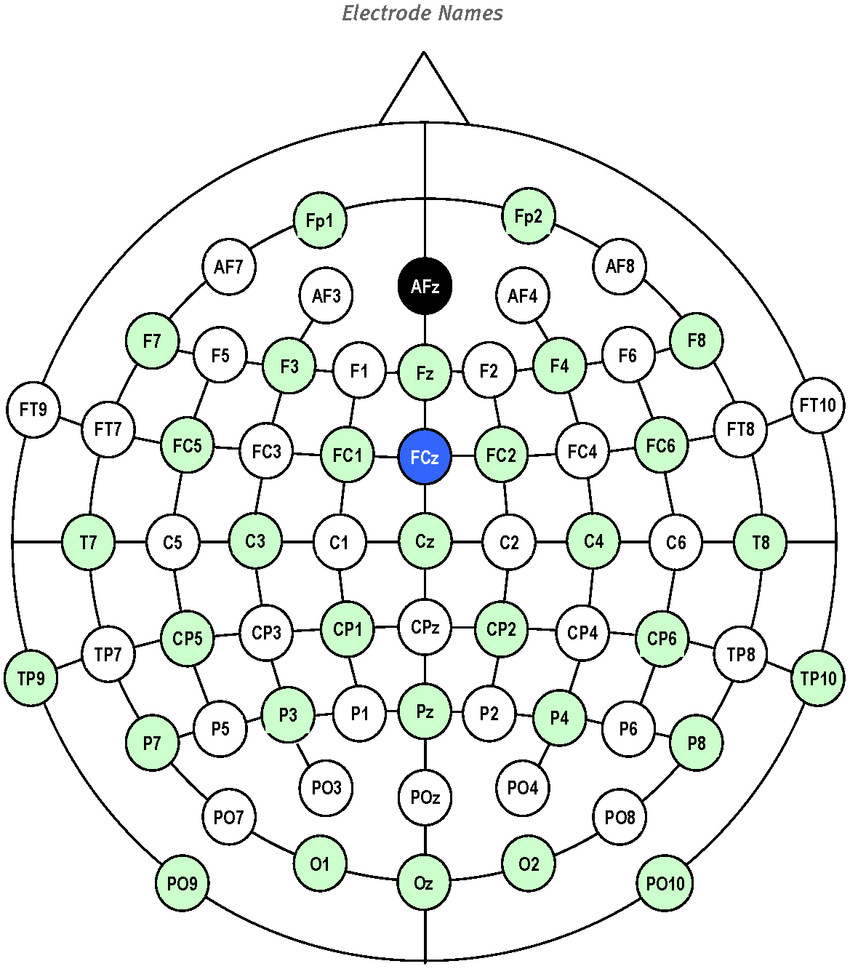

'FP1', 'FP2', 'F7', 'F8', 'AF1', 'AF2', 'FZ', 'F4', 'F3', 'FC6',
       'FC5', 'FC2', 'FC1', 'T8', 'T7', 'CZ', 'C3', 'C4', 'CP5', 'CP6',
       'CP1', 'CP2', 'P3', 'P4', 'PZ', 'P8', 'P7', 'PO2', 'PO1', 'O2',
       'O1', 'X', 'AF7', 'AF8', 'F5', 'F6', 'FT7', 'FT8', 'FPZ', 'FC4',
       'FC3', 'C6', 'C5', 'F2', 'F1', 'TP8', 'TP7', 'AFZ', 'CP3', 'CP4',
       'P5', 'P6', 'C1', 'C2', 'PO7', 'PO8', 'FCZ', 'POZ', 'OZ', 'P2',
       'P1', 'CPZ', 'nd', 'Y'

['FP1', 'FP2', 'F7', 'F8', 'AF1', 'AF2', 'FZ', 'F4', 'F3', 'FC6',
       'FC5', 'FC2', 'FC1', 'T8', 'T7', 'CZ', 'C3', 'C4', 'CP5', 'CP6',
       'CP1', 'CP2', 'P3', 'P4', 'PZ', 'P8', 'P7', 'PO2', 'PO1', 'O2',
       'O1', 'X', 'AF7', 'AF8', 'F5', 'F6', 'FT7', 'FT8', 'FPZ', 'FC4',
       'FC3', 'C6', 'C5', 'F2', 'F1', 'TP8', 'TP7', 'AFZ', 'CP3', 'CP4',
       'P5', 'P6', 'C1', 'C2', 'PO7', 'PO8', 'FCZ', 'POZ', 'OZ', 'P2',
       'P1', 'CPZ', 'nd', 'Y'

In [10]:
lista = ['FP1', 'FP2', 'F7', 'F8', 'AF1', 'AF2', 'FZ', 'F4', 'F3', 'FC6', 'FC5', 'FC2', 'FC1', 'T8', 'T7', 'CZ', 'C3', 'C4', 'CP5', 'CP6', 'CP1', 'CP2', 'P3', 'P4', 'PZ', 'P8', 'P7', 'PO2', 'PO1', 'O2', 'O1', 'X', 'AF7', 'AF8', 'F5', 'F6', 'FT7', 'FT8', 'FPZ', 'FC4', 'FC3', 'C6', 'C5', 'F2', 'F1', 'TP8', 'TP7', 'AFZ', 'CP3', 'CP4', 'P5', 'P6', 'C1', 'C2', 'PO7', 'PO8', 'FCZ', 'POZ', 'OZ', 'P2', 'P1', 'CPZ', 'nd', 'Y']

In [11]:
len(lista)

64

In [5]:
grouped_sensors = {
    'Frontal': ['FC1', 'FC2', 'FC3', 'FC4', 'FC5', 'FC6', 'FCZ', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'FZ', 'AF1', 'AF2', 'AF7', 'AF8', 'AFZ',  'FP1', 'FP2', 'FPZ', 'FT7','FT8'],
    'Central': ['C1', 'C2', 'C3', 'C4', 'C5', 'C6','CZ'],
    'Parietal': ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'PZ', 'CP1', 'CP2', 'CP3', 'CP4', 'CP5', 'CP6',  'CPZ', 'PO1', 'PO2','PO7', 'PO8', 'POZ'],
    'Occipital': ['O1', 'O2', 'OZ', ],
    'Temporal': ['TP7', 'T7', 'T8', 'TP8'],
    'Other': ['nd', 'Y', 'X',]
}

In [13]:
c = 0
for key in grouped_sensors:
  c += len(grouped_sensors[key])
print(c)

64


In [4]:
import random
import sys
from typing import Literal

import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.optim as optim
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from torch.utils.data import DataLoader, Dataset
from torchmetrics import Accuracy
import numpy as np
import pandas as pd
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def read_file(file):
    df = pd.read_csv(file)
    df = df.rename(columns={"trial number": "trial_number",
                                "sample num": "sample_num",
                                "sensor value": "sensor_value",
                                "sensor position": "sensor_position",
                                "subject identifier": "subject_identifier",
                                "matching condition": "matching_condition"})
    #check data
    assert len(df.trial_number.unique()) == 1
    trial_number = int(df.trial_number.unique()[0])
    assert len(df.sample_num.unique()) == 256
    sensor_positions = df.sensor_position.unique()
    assert len(df.subject_identifier.unique()) == 1
    subject = df.subject_identifier.unique()[0]
    assert len(df.channel.unique()) == 64
    assert len(df.name.unique()) == 1
    name = df.name.unique()[0]
    matching_condition = list(df.matching_condition.unique())
    ts = df.pivot(index="sample_num", columns="sensor_position", values="sensor_value")
    subject_class = 1 if subject == "a" else 0
    return {
        "trial_number": trial_number,
        "sensor_positions": sensor_positions,
        "name": name,
        "time_series": ts,
        "matching_condition": matching_condition,
        "subject_identifier": subject,
        "class": subject_class,
        "frontal_time_series": ts[grouped_sensors['Frontal']],
        "central_time_series": ts[grouped_sensors['Central']],
        "parietal_time_series": ts[grouped_sensors['Parietal']],
        "occipital_time_series": ts[grouped_sensors['Occipital']],
        "temporal_time_series": ts[grouped_sensors['Temporal']],
        "other_time_series": ts[grouped_sensors['Other']]
    }

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
train_files = Path(r'/content/drive/MyDrive/robotyka_4/SMNI_CMI_TRAIN').glob('**/*')
test_files = Path(r'/content/drive/MyDrive/robotyka_4/SMNI_CMI_TEST').glob('**/*')
train_files = [x for x in train_files if x.is_file()]
test_files = [x for x in test_files if x.is_file()]
train_data = dict()
test_data = dict()

for f in train_files:
    train_data[f] = read_file(f)

for f in test_files:
    test_data[f] = read_file(f)

In [8]:
rows = len(train_data)
first_key = next(iter(train_data.keys()))
cols = train_data[first_key]["sensor_positions"]

In [9]:
cols

array(['FP1', 'FP2', 'F7', 'F8', 'AF1', 'AF2', 'FZ', 'F4', 'F3', 'FC6',
       'FC5', 'FC2', 'FC1', 'T8', 'T7', 'CZ', 'C3', 'C4', 'CP5', 'CP6',
       'CP1', 'CP2', 'P3', 'P4', 'PZ', 'P8', 'P7', 'PO2', 'PO1', 'O2',
       'O1', 'X', 'AF7', 'AF8', 'F5', 'F6', 'FT7', 'FT8', 'FPZ', 'FC4',
       'FC3', 'C6', 'C5', 'F2', 'F1', 'TP8', 'TP7', 'AFZ', 'CP3', 'CP4',
       'P5', 'P6', 'C1', 'C2', 'PO7', 'PO8', 'FCZ', 'POZ', 'OZ', 'P2',
       'P1', 'CPZ', 'nd', 'Y'], dtype=object)

In [ ]:
class Custom_Dataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence, label = self.sequences[idx]
        return dict(
            sequence=torch.Tensor(sequence),
            label=torch.tensor(label).long()
        )

class Custom_data_module(pl.LightningDataModule):
    def __init__(self, train_sequences, val_sequences, test_sequences, batch_size):
        super().__init__()
        self.train_sequences = train_sequences
        self.val_sequences = val_sequences
        self.test_sequences = test_sequences
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.train_dataset = Custom_Dataset(self.train_sequences)
        self.val_dataset = Custom_Dataset(self.val_sequences)
        self.test_dataset = Custom_Dataset(self.test_sequences)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=6
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=6
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=6
        )

In [ ]:
class LSTM_Model(nn.Module):
    def __init__(self, n_features: int = 64, n_hidden: int = 256, n_layers: int = 3, dropout: float = 0.3):
        super().__init__()

        self.rnn = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            num_layers=n_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout
        )
        self.classifier = nn.Linear(2 * n_hidden, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        self.rnn.to(x.device)
        self.classifier.to(x.device)

        out, _ = self.rnn(x)
        out = out.max(-2).values
        out = self.classifier(out)
        out = self.sigmoid(out)
        return out

In [ ]:
import torch
import torch.nn as nn

class LSTM_Model(nn.Module):
    def __init__(self, n_features: int = 64, n_hidden: int = 256, n_layers: int = 3, dropout: float = 0.3):
        super().__init__()
        if n_layers > 1:
            self.rnn = nn.LSTM(
                input_size=n_features,
                hidden_size=n_hidden,
                num_layers=n_layers,
                batch_first=True,
                bidirectional=True,
                dropout=dropout
            )
        else:
            self.rnn = nn.LSTM(
                input_size=n_features,
                hidden_size=n_hidden,
                num_layers=n_layers,
                batch_first=True,
                bidirectional=True
            )
        self.classifier = nn.Linear(2 * n_hidden, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out, _ = self.rnn(x)
        out = out.max(-2).values
        out = self.classifier(out)
        out = self.sigmoid(out)
        return out

In [ ]:
class LSTM_Predictor(pl.LightningModule):
    def __init__(self, n_features, *args, **kwargs):
        super().__init__()
        self.model = LSTM_Model(n_features, *args, **kwargs)
        self.criterion = nn.BCELoss()
        self.acc = Accuracy(task="binary")

    def forward(self, x):
        return self.model(x)

    def _shared_step(self, batch, stage):
        sequences = batch["sequence"]
        labels = batch["label"]
        outputs = self(sequences)
        loss = self.criterion(outputs, labels.float().unsqueeze(-1))
        predictions = (outputs > 0.5).float().squeeze(-1)
        accuracy = self.acc(predictions, labels.int())
        self.log(f"{stage}_loss", loss, prog_bar=True, logger=True)
        self.log(f"{stage}_accuracy", accuracy, prog_bar=True, logger=True)
        return {"loss": loss, "accuracy": accuracy}

    def training_step(self, batch, batch_idx):
        return self._shared_step(batch, "train")

    def validation_step(self, batch, batch_idx):
        return self._shared_step(batch, "val")

    def test_step(self, batch, batch_idx):
        return self._shared_step(batch, "test")

    def predict(self, sequence):
        self.eval()
        with torch.no_grad():
            sequence = sequence.to(self.device)
            output = self.forward(torch.Tensor(sequence))
            predictions = (output > 0.5).float().squeeze(-1)
        return predictions

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.001)

# Only frontal

In [ ]:
rows = len(train_data)
first_key = next(iter(train_data.keys()))
cols = train_data[first_key]["frontal_time_series"].shape[1]

train_sequences = [(train_data[key]['frontal_time_series'].to_numpy(), train_data[key]['class']) for key in train_data]
test_sequences = [(test_data[key]['frontal_time_series'].to_numpy(), test_data[key]['class']) for key in test_data]

In [ ]:
random.shuffle(test_sequences)
val_sequences = test_sequences[:100]
test_sequences = test_sequences[100:]

In [ ]:
print(train_sequences[0][0].shape)
print(test_sequences[0][0].shape)
print(val_sequences[0][0].shape)

(256, 25)
(256, 25)
(256, 25)


In [ ]:
N_EP0CHS = 5
BATCH_SIZE = 32

data_module = Custom_data_module(train_sequences, val_sequences, test_sequences, BATCH_SIZE)
model = LSTM_Predictor(n_features=25, n_hidden=256, n_layers=3, dropout=0.25)

checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min"
)

logger = TensorBoardLogger("lightning_logs", name="EEG")

trainer = pl.Trainer(
    logger=logger,
    callbacks=checkpoint_callback,
    max_epochs=N_EP0CHS,
)

trainer.fit(model, data_module)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type           | Params
---------------------------------------------
0 | model     | LSTM_Model     | 3.7 M 
1 | criterion | BCELoss        | 0     
2 | acc       | BinaryAccuracy | 0     
---------------------------------------------
3.7 M     Trainable params
0         Non-trainable params
3.7 M     Total params
14.936    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 30: 'val_loss' reached 0.42309 (best 0.42309), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 60: 'val_loss' reached 0.31227 (best 0.31227), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 90: 'val_loss' reached 0.24327 (best 0.24327), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 120: 'val_loss' reached 0.17791 (best 0.17791), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 150: 'val_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [ ]:
trainer.test(dataloaders=data_module.test_dataloader())

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/checkpoints/best-checkpoint.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/checkpoints/best-checkpoint.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9127907156944275     │
│         test_loss         │    0.23652324080467224    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.23652324080467224, 'test_accuracy': 0.9127907156944275}]

LightGBM

Accuracy: 0.843750

F1 Score: 0.849095


# Only central

In [ ]:
rows = len(train_data)
first_key = next(iter(train_data.keys()))
cols = train_data[first_key]["central_time_series"].shape[1]

train_sequences = [(train_data[key]['central_time_series'].to_numpy(), train_data[key]['class']) for key in train_data]
test_sequences = [(test_data[key]['central_time_series'].to_numpy(), test_data[key]['class']) for key in test_data]

In [ ]:
random.shuffle(test_sequences)
val_sequences = test_sequences[:100]
test_sequences = test_sequences[100:]

In [ ]:
print(train_sequences[0][0].shape)
print(test_sequences[0][0].shape)
print(val_sequences[0][0].shape)

(256, 8)
(256, 8)
(256, 8)


In [ ]:
N_EP0CHS = 5
BATCH_SIZE = 32

data_module = Custom_data_module(train_sequences, val_sequences, test_sequences, BATCH_SIZE)
model = LSTM_Predictor(n_features=8, n_hidden=256, n_layers=3, dropout=0.25)

checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min"
)

logger = TensorBoardLogger("lightning_logs", name="EEG")

trainer = pl.Trainer(
    logger=logger,
    callbacks=checkpoint_callback,
    max_epochs=N_EP0CHS,
)

trainer.fit(model, data_module)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type           | Params
---------------------------------------------
0 | model     | LSTM_Model     | 3.7 M 
1 | criterion | BCELoss        | 0     
2 | acc       | BinaryAccuracy | 0     
---------------------------------------------
3.7 M     Trainable params
0         Non-trainable params
3.7 M     Total params
14.797    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 30: 'val_loss' reached 0.57393 (best 0.57393), saving model to '/content/checkpoints/best-checkpoint-v1.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 60: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 90: 'val_loss' reached 0.54552 (best 0.54552), saving model to '/content/checkpoints/best-checkpoint-v1.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 120: 'val_loss' reached 0.41824 (best 0.41824), saving model to '/content/checkpoints/best-checkpoint-v1.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 150: 'val_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [ ]:
trainer.test(dataloaders=data_module.test_dataloader())

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/checkpoints/best-checkpoint-v1.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/checkpoints/best-checkpoint-v1.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.804651141166687     │
│         test_loss         │    0.4280118942260742     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.4280118942260742, 'test_accuracy': 0.804651141166687}]

LightGBM

Accuracy: 0.747917

F1 Score: 0.738852


# Only parietal

In [ ]:
rows = len(train_data)
first_key = next(iter(train_data.keys()))
cols = train_data[first_key]["parietal_time_series"].shape[1]

train_sequences = [(train_data[key]['parietal_time_series'].to_numpy(), train_data[key]['class']) for key in train_data]
test_sequences = [(test_data[key]['parietal_time_series'].to_numpy(), test_data[key]['class']) for key in test_data]

In [ ]:
random.shuffle(test_sequences)
val_sequences = test_sequences[:100]
test_sequences = test_sequences[100:]

In [ ]:
print(train_sequences[0][0].shape)
print(test_sequences[0][0].shape)
print(val_sequences[0][0].shape)

(256, 21)
(256, 21)
(256, 21)


In [ ]:
N_EP0CHS = 5
BATCH_SIZE = 32

data_module = Custom_data_module(train_sequences, val_sequences, test_sequences, BATCH_SIZE)
model = LSTM_Predictor(n_features=train_sequences[0][0].shape[1], n_hidden=256, n_layers=3, dropout=0.25)

checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min"
)

logger = TensorBoardLogger("lightning_logs", name="EEG")

trainer = pl.Trainer(
    logger=logger,
    callbacks=checkpoint_callback,
    max_epochs=N_EP0CHS,
)

trainer.fit(model, data_module)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /content/checkpoints exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type           | Params
---------------------------------------------
0 | model     | LSTM_Model     | 3.7 M 
1 | criterion | BCELoss        | 0     
2 | acc       | BinaryAccuracy | 0     
---------------------------------------------
3.7 M     Trainable params
0         Non-trainable params
3.7 M     Total params
14.903    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 30: 'val_loss' reached 0.38956 (best 0.38956), saving model to '/content/checkpoints/best-checkpoint-v2.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 60: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 90: 'val_loss' reached 0.37296 (best 0.37296), saving model to '/content/checkpoints/best-checkpoint-v2.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 120: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 150: 'val_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [ ]:
trainer.test(dataloaders=data_module.test_dataloader())

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/checkpoints/best-checkpoint-v2.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/checkpoints/best-checkpoint-v2.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8209302425384521     │
│         test_loss         │    0.4740990996360779     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.4740990996360779, 'test_accuracy': 0.8209302425384521}]

LightGBM

Accuracy: 0.761667

F1 Score: 0.737607


# Only occipital

In [ ]:
rows = len(train_data)
first_key = next(iter(train_data.keys()))
cols = train_data[first_key]["occipital_time_series"].shape[1]

train_sequences = [(train_data[key]['occipital_time_series'].to_numpy(), train_data[key]['class']) for key in train_data]
test_sequences = [(test_data[key]['occipital_time_series'].to_numpy(), test_data[key]['class']) for key in test_data]

In [ ]:
random.shuffle(test_sequences)
val_sequences = test_sequences[:100]
test_sequences = test_sequences[100:]

In [ ]:
print(train_sequences[0][0].shape)
print(test_sequences[0][0].shape)
print(val_sequences[0][0].shape)

(256, 3)
(256, 3)
(256, 3)


In [ ]:
N_EP0CHS = 5
BATCH_SIZE = 32

data_module = Custom_data_module(train_sequences, val_sequences, test_sequences, BATCH_SIZE)
model = LSTM_Predictor(n_features=train_sequences[0][0].shape[1], n_hidden=256, n_layers=3, dropout=0.25)

checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min"
)

logger = TensorBoardLogger("lightning_logs", name="EEG")

trainer = pl.Trainer(
    logger=logger,
    callbacks=checkpoint_callback,
    max_epochs=N_EP0CHS,
)

trainer.fit(model, data_module)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type           | Params
---------------------------------------------
0 | model     | LSTM_Model     | 3.7 M 
1 | criterion | BCELoss        | 0     
2 | acc       | BinaryAccuracy | 0     
---------------------------------------------
3.7 M     Trainable params
0         Non-trainable params
3.7 M     Total params
14.756    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 30: 'val_loss' reached 0.70140 (best 0.70140), saving model to '/content/checkpoints/best-checkpoint-v3.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 60: 'val_loss' reached 0.59744 (best 0.59744), saving model to '/content/checkpoints/best-checkpoint-v3.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 90: 'val_loss' reached 0.57164 (best 0.57164), saving model to '/content/checkpoints/best-checkpoint-v3.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 120: 'val_loss' reached 0.53012 (best 0.53012), saving model to '/content/checkpoints/best-checkpoint-v3.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 150: 'val_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [ ]:
trainer.test(dataloaders=data_module.test_dataloader())

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/checkpoints/best-checkpoint-v3.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/checkpoints/best-checkpoint-v3.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.7127906680107117     │
│         test_loss         │    0.5645440220832825     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5645440220832825, 'test_accuracy': 0.7127906680107117}]

LightGBM

Accuracy: 0.689583

F1 Score: 0.680942


# Only Temporal

In [ ]:
rows = len(train_data)
first_key = next(iter(train_data.keys()))
cols = train_data[first_key]["temporal_time_series"].shape[1]

train_sequences = [(train_data[key]['temporal_time_series'].to_numpy(), train_data[key]['class']) for key in train_data]
test_sequences = [(test_data[key]['temporal_time_series'].to_numpy(), test_data[key]['class']) for key in test_data]

In [ ]:
random.shuffle(test_sequences)
val_sequences = test_sequences[:100]
test_sequences = test_sequences[100:]

In [ ]:
print(train_sequences[0][0].shape)
print(test_sequences[0][0].shape)
print(val_sequences[0][0].shape)

(256, 4)
(256, 4)
(256, 4)


In [ ]:
N_EP0CHS = 5
BATCH_SIZE = 32

data_module = Custom_data_module(train_sequences, val_sequences, test_sequences, BATCH_SIZE)
model = LSTM_Predictor(n_features=train_sequences[0][0].shape[1], n_hidden=256, n_layers=3, dropout=0.25)

checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min"
)

logger = TensorBoardLogger("lightning_logs", name="EEG")

trainer = pl.Trainer(
    logger=logger,
    callbacks=checkpoint_callback,
    max_epochs=N_EP0CHS,
)

trainer.fit(model, data_module)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type           | Params
---------------------------------------------
0 | model     | LSTM_Model     | 3.7 M 
1 | criterion | BCELoss        | 0     
2 | acc       | BinaryAccuracy | 0     
---------------------------------------------
3.7 M     Trainable params
0         Non-trainable params
3.7 M     Total params
14.764    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 30: 'val_loss' reached 0.68861 (best 0.68861), saving model to '/content/checkpoints/best-checkpoint-v4.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 60: 'val_loss' reached 0.64038 (best 0.64038), saving model to '/content/checkpoints/best-checkpoint-v4.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 90: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 120: 'val_loss' reached 0.60737 (best 0.60737), saving model to '/content/checkpoints/best-checkpoint-v4.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 150: 'val_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [ ]:
trainer.test(dataloaders=data_module.test_dataloader())

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/checkpoints/best-checkpoint-v4.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/checkpoints/best-checkpoint-v4.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.6790697574615479     │
│         test_loss         │    0.5994352102279663     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5994352102279663, 'test_accuracy': 0.6790697574615479}]

LightGBM

Accuracy: 0.664583

F1 Score: 0.658174


# Only other

In [ ]:
rows = len(train_data)
first_key = next(iter(train_data.keys()))
cols = train_data[first_key]["other_time_series"].shape[1]

train_sequences = [(train_data[key]['other_time_series'].to_numpy(), train_data[key]['class']) for key in train_data]
test_sequences = [(test_data[key]['other_time_series'].to_numpy(), test_data[key]['class']) for key in test_data]

In [ ]:
random.shuffle(test_sequences)
val_sequences = test_sequences[:100]
test_sequences = test_sequences[100:]

In [ ]:
print(train_sequences[0][0].shape)
print(test_sequences[0][0].shape)
print(val_sequences[0][0].shape)

(256, 3)
(256, 3)
(256, 3)


In [ ]:
N_EP0CHS = 5
BATCH_SIZE = 32

data_module = Custom_data_module(train_sequences, val_sequences, test_sequences, BATCH_SIZE)
model = LSTM_Predictor(n_features=train_sequences[0][0].shape[1], n_hidden=256, n_layers=3, dropout=0.25)

checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min"
)

logger = TensorBoardLogger("lightning_logs", name="EEG")

trainer = pl.Trainer(
    logger=logger,
    callbacks=checkpoint_callback,
    max_epochs=N_EP0CHS,
)

trainer.fit(model, data_module)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type           | Params
---------------------------------------------
0 | model     | LSTM_Model     | 3.7 M 
1 | criterion | BCELoss        | 0     
2 | acc       | BinaryAccuracy | 0     
---------------------------------------------
3.7 M     Trainable params
0         Non-trainable params
3.7 M     Total params
14.756    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 30: 'val_loss' reached 0.58515 (best 0.58515), saving model to '/content/checkpoints/best-checkpoint-v5.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 60: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 90: 'val_loss' reached 0.56000 (best 0.56000), saving model to '/content/checkpoints/best-checkpoint-v5.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 120: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 150: 'val_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [ ]:
trainer.test(dataloaders=data_module.test_dataloader())

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/checkpoints/best-checkpoint-v5.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/checkpoints/best-checkpoint-v5.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.7011628150939941     │
│         test_loss         │    0.5703455209732056     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5703455209732056, 'test_accuracy': 0.7011628150939941}]

LightGBM

Accuracy: 0.700000

F1 Score: 0.700000


Conclusions:

Based on the two model types (LightGBM and LSTM) we can clearly see that LSTMs outperform LightGBM in this type of data. Best performance was acheived on frontal data. Let's see if we can tune the model to get even better results on frontal data.

# Longer training on frontal data

In [ ]:
rows = len(train_data)
first_key = next(iter(train_data.keys()))
cols = train_data[first_key]["frontal_time_series"].shape[1]

train_sequences = [(train_data[key]['frontal_time_series'].to_numpy(), train_data[key]['class']) for key in train_data]
test_sequences = [(test_data[key]['frontal_time_series'].to_numpy(), test_data[key]['class']) for key in test_data]

In [ ]:
random.shuffle(test_sequences)
val_sequences = test_sequences[:100]
test_sequences = test_sequences[100:]

In [ ]:
print(train_sequences[0][0].shape)
print(test_sequences[0][0].shape)
print(val_sequences[0][0].shape)

(256, 25)
(256, 25)
(256, 25)


In [ ]:
from pytorch_lightning.callbacks import EarlyStopping

N_EPOCHS = 50
BATCH_SIZE = 32

data_module = Custom_data_module(train_sequences, val_sequences, test_sequences, BATCH_SIZE)
model = LSTM_Predictor(n_features=train_sequences[0][0].shape[1], n_hidden=256, n_layers=3, dropout=0.25)

checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min"
)

early_stopping_callback = EarlyStopping(
    monitor="val_loss",
    patience=3,
    verbose=True,
    mode="min"
)

logger = TensorBoardLogger("lightning_logs", name="EEG")

trainer = pl.Trainer(
    logger=logger,
    callbacks=[checkpoint_callback, early_stopping_callback],
    max_epochs=N_EPOCHS,
)

trainer.fit(model, data_module)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type           | Params
---------------------------------------------
0 | model     | LSTM_Model     | 3.7 M 
1 | criterion | BCELoss        | 0     
2 | acc       | BinaryAccuracy | 0     
---------------------------------------------
3.7 M     Trainable params
0         Non-trainable params
3.7 M     Total params
14.936    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.483
INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 30: 'val_loss' reached 0.48252 (best 0.48252), saving model to '/content/checkpoints/best-checkpoint-v7.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 60: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.145 >= min_delta = 0.0. New best score: 0.337
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 90: 'val_loss' reached 0.33734 (best 0.33734), saving model to '/content/checkpoints/best-checkpoint-v7.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 120: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 0.302
INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 150: 'val_loss' reached 0.30196 (best 0.30196), saving model to '/content/checkpoints/best-checkpoint-v7.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 180: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 210: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 3 records. Best score: 0.302. Signaling Trainer to stop.
INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 240: 'val_loss' was not in top 1


In [ ]:
trainer.test(dataloaders=data_module.test_dataloader())

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/checkpoints/best-checkpoint-v7.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/checkpoints/best-checkpoint-v7.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8581395149230957     │
│         test_loss         │    0.35826805233955383    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.35826805233955383, 'test_accuracy': 0.8581395149230957}]

No improvement - hard reproducibility, more tests need to be done on a set seed.

We are pleased with the results already - but now it still rests that we shall experiment with n_hidden, n_layer, dropout and batch_size. Further experiments will lead us to obtain results which will be presented on the final form.
Apart from that, we tried tsaug, but it didn't prove to be much. We want to focus this week on finalizing the best results and adding visualizations to the presentation to enhance it. We were inspired by https://www.mattcraddock.com/blog/2017/02/25/erp-visualization-creating-topographical-scalp-maps-part-1/ and want to reproduce it for this data.
